<IPython.core.display.Javascript object>


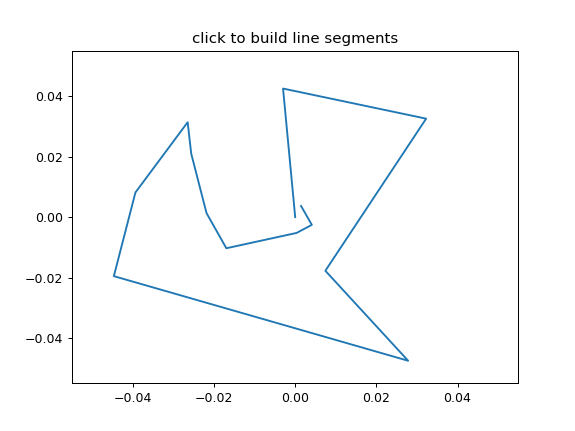

In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt

class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click to build line segments')
line, = ax.plot([0], [0])  # empty line
linebuilder = LineBuilder(line)

plt.show()

<IPython.core.display.Javascript object>


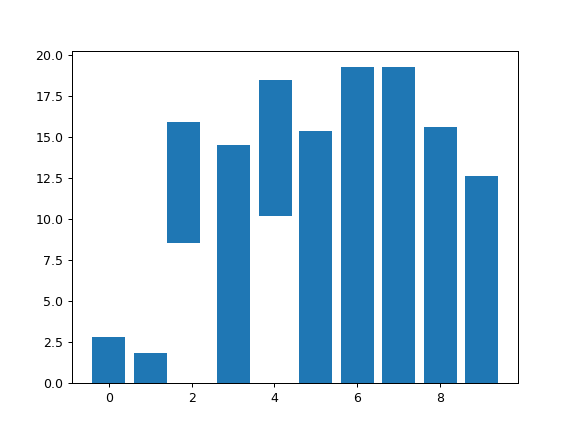

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        'on button press we will see if the mouse is over us and store some data'
        if event.inaxes != self.rect.axes: return

        contains, attrd = self.rect.contains(event)
        if not contains: return
        print('event contains', self.rect.xy)
        x0, y0 = self.rect.xy
        self.press = x0, y0, event.xdata, event.ydata

    def on_motion(self, event):
        'on motion we will move the rect if the mouse is over us'
        if self.press is None: return
        if event.inaxes != self.rect.axes: return
        x0, y0, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        #print('x0=%f, xpress=%f, event.xdata=%f, dx=%f, x0+dx=%f' %
        #      (x0, xpress, event.xdata, dx, x0+dx))
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        self.rect.figure.canvas.draw()


    def on_release(self, event):
        'on release we reset the press data'
        self.press = None
        self.rect.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig = plt.figure()
ax = fig.add_subplot(111)
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

<IPython.core.display.Javascript object>


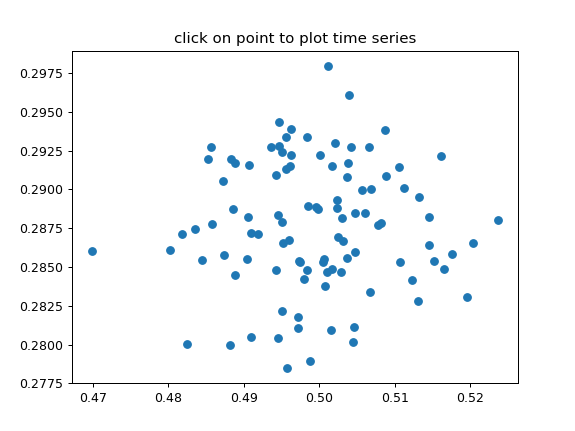

In [4]:
"""
compute the mean and stddev of 100 data sets and plot mean vs. stddev.
When you click on one of the mu, sigma points, plot the raw data from
the dataset that generated the mean and stddev
"""
import numpy as np
import matplotlib.pyplot as plt

X = np.random.rand(100, 1000)
xs = np.mean(X, axis=1)
ys = np.std(X, axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click on point to plot time series')
line, = ax.plot(xs, ys, 'o', picker=5)  # 5 points tolerance


def onpick(event):

    if event.artist!=line: return True

    N = len(event.ind)
    if not N: return True


    figi = plt.figure()
    for subplotnum, dataind in enumerate(event.ind):
        ax = figi.add_subplot(N,1,subplotnum+1)
        ax.plot(X[dataind])
        ax.text(0.05, 0.9, 'mu=%1.3f\nsigma=%1.3f'%(xs[dataind], ys[dataind]),
                transform=ax.transAxes, va='top')
        ax.set_ylim(-0.5, 1.5)
    figi.show()
    return True

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()

<IPython.core.display.Javascript object>


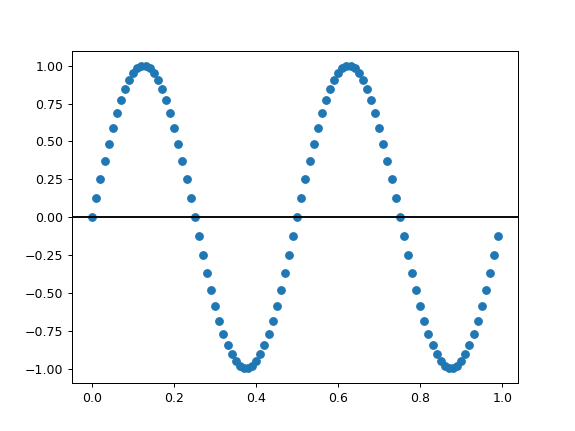

<IPython.core.display.Javascript object>


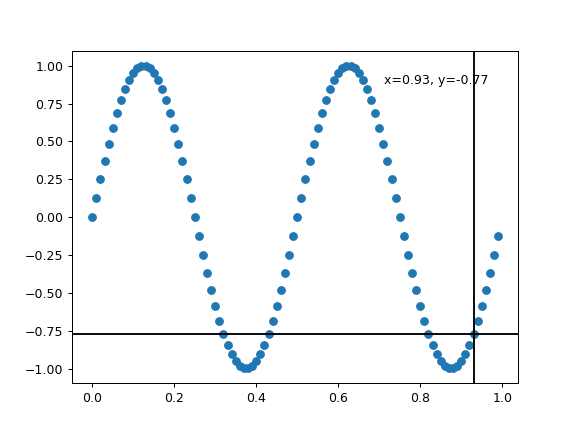

In [6]:
import matplotlib.pyplot as plt
import numpy as np


class Cursor:
    def __init__(self, ax):
        self.ax = ax
        self.lx = ax.axhline(color='k')  # the horiz line

        # text location in axes coords
        self.txt = ax.text(0.7, 0.9, '', transform=ax.transAxes)

    def mouse_move(self, event):
        if not event.inaxes:
            return

        x = event.xdata
        # update the line positions
        self.lx.set_ydata(y)

        self.txt.set_text('x=%1.2f' % (x))
        self.ax.figure.canvas.draw()


class SnaptoCursor:
    """
    Like Cursor but the crosshair snaps to the nearest x, y point.
    For simplicity, this assumes that *x* is sorted.
    """

    def __init__(self, ax, x, y):
        self.ax = ax
        self.lx = ax.axhline(color='k')  # the horiz line
        self.ly = ax.axvline(color='k')  # the vert line
        self.x = x
        self.y = y
        # text location in axes coords
        self.txt = ax.text(0.7, 0.9, '', transform=ax.transAxes)

    def mouse_move(self, event):
        if not event.inaxes:
            return

        x, y = event.xdata, event.ydata
        indx = min(np.searchsorted(self.x, x), len(self.x) - 1)
        x = self.x[indx]
        y = self.y[indx]
        # update the line positions
        self.lx.set_ydata(y)
        self.ly.set_xdata(x)

        self.txt.set_text('x=%1.2f, y=%1.2f' % (x, y))
        print('x=%1.2f, y=%1.2f' % (x, y))
        self.ax.figure.canvas.draw()


t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2 * 2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s, 'o')
cursor = Cursor(ax)
fig.canvas.mpl_connect('motion_notify_event', cursor.mouse_move)

fig, ax = plt.subplots()
ax.plot(t, s, 'o')
snap_cursor = SnaptoCursor(ax, t, s)
fig.canvas.mpl_connect('motion_notify_event', snap_cursor.mouse_move)

plt.show()